<a href="https://colab.research.google.com/github/A1171/ColabNotebooks/blob/main/ResNet1D_%D0%B4%D0%BB%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet1D переделанная мной из двухмерной на одномерную. Базовые блоки написаны как классы. Составлены несколько моделей.

In [1]:
import numpy as np
#%tensorflow_version 1.x
import keras
from keras import regularizers
from keras import layers
from keras.models import load_model
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
import pickle
import math
from sklearn.preprocessing import LabelBinarizer,StandardScaler,MinMaxScaler
import gc

In [2]:
#Res-net 1D
class DBL(keras.layers.Layer):
    def __init__(self, filters, kernel, strides=1, batch_norm=True,l2Conv=0.0005):
        super(DBL, self).__init__()
        self.filters=filters
        self.kernel_size=kernel
        self.strides=strides
        self.batch_norm=batch_norm
        self.padding='same' if strides == 1 else 'valid'
        self.ZeroPadding1D=layers.ZeroPadding1D(padding=1)
        self.l2Conv=l2Conv
        #print(self.padding)
        self.Conv1D=layers.Conv1D(self.filters,self.kernel_size,strides=self.strides, padding=self.padding,use_bias=not self.batch_norm, kernel_regularizer=regularizers.l2(self.l2Conv))#
        self.BatchNormalization=layers.BatchNormalization(epsilon=0.001)
        self.LeakyReLU=layers.LeakyReLU(alpha=0.1)
    def call(self, inputs):
        if self.strides> 1 :
          x = self.ZeroPadding1D(inputs)
        else:
          x = inputs
        x = self.Conv1D(x)
        if self.batch_norm:
          x = self.BatchNormalization(x)
          x = self.LeakyReLU(x)
        return x
class Res_unit(keras.layers.Layer):
    def __init__(self, filters,l2Conv=0.0005):
        super(Res_unit, self).__init__()
        self.filters=filters
        self.DBL1=DBL(filters // 2, kernel=1,l2Conv=l2Conv)
        self.DBL2=DBL(filters, kernel=3,l2Conv=l2Conv)
        self.add=layers.add
    def call(self, inputs):
      skip_connection = inputs
      x = self.DBL1(inputs)
      x = self.DBL2(x)
      x = self.add([skip_connection , x])
      return x
class ResBlock(keras.layers.Layer):
    def __init__(self, filters, blocks,l2Conv=0.0005):
        super(ResBlock, self).__init__()
        self.filters=filters
        self.blocks=blocks
        self.DBL=DBL(self.filters, kernel=3, strides=2,l2Conv=l2Conv)
        self.ResBlocks=[Res_unit(self.filters,l2Conv=l2Conv) for i in range(self.blocks)]
    def call(self, inputs):
      #print(len(self.ResBlocks))
      x = self.DBL(inputs)
      for i in range(self.blocks):
        #print(x.shape)
        x = self.ResBlocks[i](x)
      return x
def create_ResNet_model(Shape1,Neurons,Filters,l2Conv=0.0005,OutActivation='softmax',OutNeurons=3):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivity1=0
  l2Dense=0.001
  x = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs1)
  x = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*8, blocks=8,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*16, blocks=8,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*32, blocks=4,l2Conv=l2Conv)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(OutNeurons, activation=OutActivation)(x)
  return keras.Model(inputs=inputs1, outputs=x)
def create_ResNet_short(Shape1,Neurons,Filters,l2Conv=0.0005,OutActivation='softmax',OutNeurons=3):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivity1=0
  l2Dense=0.001
  x = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs1)
  x = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(OutNeurons, activation=OutActivation)(x)
  return keras.Model(inputs=inputs1, outputs=x)
def create_ResNet_short3In(Shape1,Shape2,Shape3,Neurons,Filters,l2Conv=0.0005,OutActivation='softmax',OutNeurons=3):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  lambdaActivity1=0
  l2Dense=0.001
  x = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs1)
  x = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x)
  x = layers.Flatten()(x)
  x1 = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs2)
  x1 = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x1)
  x1 = layers.Flatten()(x1)
  x2 = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs3)
  x2 = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x2)
  x2 = layers.Flatten()(x2)
  x = layers.Concatenate()([x,x1,x2])
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(OutNeurons, activation=OutActivation)(x)
  return keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=x)

def create_ResNet_Vshort3In(Shape1,Shape2,Shape3,Neurons,Filters,l2Conv=0.0005,OutActivation='softmax',OutNeurons=3):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  lambdaActivity1=0
  l2Dense=0.001
  x = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs1)
  x = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*4, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*8, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*16, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*32, blocks=1,l2Conv=l2Conv)(x)
  x = layers.Flatten()(x)
  x1 = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs2)
  x1 = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*4, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*8, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*16, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*32, blocks=1,l2Conv=l2Conv)(x1)
  x1 = layers.Flatten()(x1)
  x2 = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs3)
  x2 = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*4, blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*8, blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*16, blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=Filters*32, blocks=1,l2Conv=l2Conv)(x2)
  x2 = layers.Flatten()(x2)
  x = layers.Concatenate()([x,x1,x2])
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(OutNeurons, activation=OutActivation)(x)
  return keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=x)

def create_ResNet_short4In(Shape1,Shape2,Shape3,Shape4,Neurons,Filters,l2Conv=0.0005,OutActivation='softmax',OutNeurons=3):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  inputs4 = keras.Input(shape=Shape4)
  lambdaActivity1=0
  l2Dense=0.001
  x = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs1)
  x = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x)
  x = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x)
  x = layers.Flatten()(x)
  x1 = DBL(filters=Filters, kernel=3,l2Conv=l2Conv)(inputs2)
  x1 = ResBlock(filters=Filters*2, blocks=1,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*4, blocks=2,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*8, blocks=3,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*16, blocks=3,l2Conv=l2Conv)(x1)
  x1 = ResBlock(filters=Filters*32, blocks=2,l2Conv=l2Conv)(x1)
  x1 = layers.Flatten()(x1)
  x2 = DBL(filters=int(Filters*0.7), kernel=3,l2Conv=l2Conv)(inputs3)
  x2 = ResBlock(filters=int(Filters*2*0.7), blocks=1,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=int(Filters*4*0.7), blocks=2,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=int(Filters*8*0.7), blocks=3,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=int(Filters*16*0.7), blocks=3,l2Conv=l2Conv)(x2)
  x2 = ResBlock(filters=int(Filters*32*0.7), blocks=2,l2Conv=l2Conv)(x2)
  x2 = layers.Flatten()(x2)
  x3 = DBL(filters=int(Filters*0.5), kernel=3,l2Conv=l2Conv)(inputs4)
  x3 = ResBlock(filters=int(Filters*2*0.5), blocks=1,l2Conv=l2Conv)(x3)
  x3 = ResBlock(filters=int(Filters*4*0.5), blocks=2,l2Conv=l2Conv)(x3)
  x3 = ResBlock(filters=int(Filters*8*0.5), blocks=3,l2Conv=l2Conv)(x3)
  x3 = ResBlock(filters=int(Filters*16*0.5), blocks=3,l2Conv=l2Conv)(x3)
  x3 = ResBlock(filters=int(Filters*32*0.5), blocks=2,l2Conv=l2Conv)(x3)
  x3 = layers.Flatten()(x3)
  x = layers.Concatenate()([x,x1,x2,x3])
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(OutNeurons, activation=OutActivation)(x)
  return keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4], outputs=x)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SequencyLen=32
RecordsStep=1
NClasses=3
batch_size=4096

In [18]:
HistoryFileDir="drive/My Drive/NN/DiplShares/"
#Загрузка массива данных и разбивка на выборки
AdditNames=["SBER_M5_Linear6"]
TrainTestGap=SequencyLen+100
trainPart=0.8
testPart=0.1
x_features=[8,9,10,11,12,15,18,19,21]
x_data_1 = np.loadtxt(HistoryFileDir+"DataFileI1_"+AdditNames[0]+'.txt')
y_data_1 = np.loadtxt(HistoryFileDir+"DataFileO1_"+AdditNames[0]+'.txt')
x_data_tr=x_data_1[:int(len(x_data_1)*trainPart)]
x_data_test=x_data_1[int(len(x_data_1)*trainPart+TrainTestGap):int(len(x_data_1)*(trainPart+testPart)+TrainTestGap)]
x_data_val=x_data_1[int(len(x_data_1)*(trainPart+testPart)+TrainTestGap*2):]
y_in_data_tr=y_data_1[:int(len(x_data_1)*trainPart)]
y_in_data_test=y_data_1[int(len(x_data_1)*trainPart+TrainTestGap):int(len(x_data_1)*(trainPart+testPart)+TrainTestGap)]
y_in_data_val=y_data_1[int(len(x_data_1)*(trainPart+testPart)+TrainTestGap*2):]

StandardScaler1=StandardScaler()
StandardScaler1.fit(x_data_tr[:,x_features])
x_data_tr_scaled=StandardScaler1.transform(x_data_tr[:,x_features])
x_data_test_scaled=StandardScaler1.transform(x_data_tr[:,x_features])
x_data_tr_datagen=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_data_tr_scaled,y_in_data_tr[:,-3:],SequencyLen,sampling_rate=1,stride=1,batch_size=batch_size)
x_data_tst_datagen=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_data_tr_scaled,y_in_data_tr[:,-3:],SequencyLen,sampling_rate=1,stride=1,batch_size=batch_size)




In [19]:
x_data_tr_datagen[0][0].shape

(4096, 32, 9)

In [16]:
adamopt=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [15]:
def GetWeightMatrixClassic(TemplTr):
    ClassX=[]
    Argmax=np.argmax(TemplTr,axis=1)
    for i in range(TemplTr.shape[1]):
      ClassX.append(len(TemplTr[Argmax==i]))
    WeightMatrix=1/np.array(ClassX)
    WeightMatrix=WeightMatrix/np.amax(WeightMatrix)
    Multiplier=np.sum(1/WeightMatrix)/len(WeightMatrix)
    WeightMatrix=WeightMatrix*Multiplier
    WeightMatrix2=dict(enumerate(WeightMatrix.flatten(), 0))
    return WeightMatrix2

In [17]:
WeightMatrix2=GetWeightMatrixClassic(y_in_data_tr[:,-3:])
WeightMatrix2

{0: 3.141187948089663, 1: 0.4218224915529476, 2: 3.2156029357116314}

In [25]:
#Границы классификации для предварительной оценки доходности в калбеке
model_10=create_ResNet_model(x_data_tr_datagen[0][0][0].shape,20,8,l2Conv=0.00005,OutActivation='softmax',OutNeurons=3)
model_10.compile(loss="categorical_crossentropy",optimizer=adamopt,metrics=['accuracy','mae'])
history1=model_10.fit(x_data_tr_datagen,validation_data=x_data_tst_datagen,class_weight=WeightMatrix2,epochs=10,verbose=1)#

Epoch 1/10
68/68 [==============================] - 230s 3s/step - loss: 1.4141 - accuracy: 0.4238 - mae: 0.4398 - val_loss: 1.3072 - val_accuracy: 0.4426 - val_mae: 0.4449
Epoch 2/10
68/68 [==============================] - 206s 3s/step - loss: 1.3066 - accuracy: 0.4678 - mae: 0.4389 - val_loss: 1.1971 - val_accuracy: 0.7440 - val_mae: 0.4190
Epoch 3/10
68/68 [==============================] - 210s 3s/step - loss: 1.2928 - accuracy: 0.4827 - mae: 0.4377 - val_loss: 1.2552 - val_accuracy: 0.6186 - val_mae: 0.4323
Epoch 4/10
68/68 [==============================] - 215s 3s/step - loss: 1.2817 - accuracy: 0.4876 - mae: 0.4347 - val_loss: 1.3354 - val_accuracy: 0.4645 - val_mae: 0.4474
Epoch 5/10
68/68 [==============================] - 206s 3s/step - loss: 1.2729 - accuracy: 0.4648 - mae: 0.4358 - val_loss: 1.2881 - val_accuracy: 0.5144 - val_mae: 0.4369
Epoch 6/10
68/68 [==============================] - 200s 3s/step - loss: 1.2634 - accuracy: 0.4693 - mae: 0.4330 - val_loss: 1.3202 - v

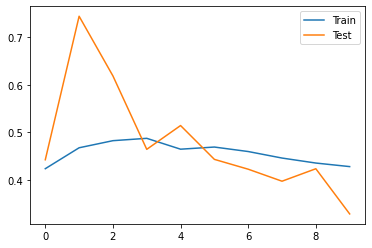

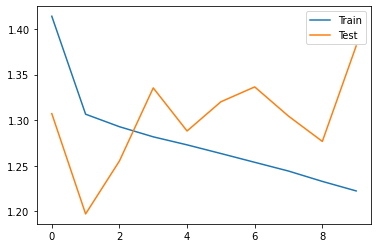

In [26]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'],label='Train')
plt.plot(history1.history['val_accuracy'],label='Test')
plt.legend()
plt.show()
plt.plot(history1.history['loss'],label='Train')
plt.plot(history1.history['val_loss'],label='Test')
plt.legend()
plt.show()